In [ ]:
# from __future__ import division

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
pathname = '/home/pboord/flask/maxvp/app/static'
img = cv2.imread(pathname+'/yelpHongKong4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
H, W = img.shape[:2]
H, W

(1000, 1000)

In [2]:
# Canny
# http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html
cv2.CV_PI = 3.1415926535897932384626433832795
thrs1 = 50
thrs2 = 200
cannyEdge = cv2.Canny(gray, thrs1, thrs2, apertureSize=3)
cv2.imshow('Canny', cannyEdge)
cv2.imwrite(pathname+'/Canny.jpg',cannyEdge)
# http://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlinesp
lines = cv2.HoughLinesP(cannyEdge,1, cv2.CV_PI/180, 80, 30, 10)[:,0,:]
# with Vert
color_dst = cv2.cvtColor(cannyEdge,cv2.COLOR_GRAY2BGR)
for i in range(0,lines.shape[0]):
    cv2.line(color_dst,(lines[i][0],lines[i][1]), (lines[i][2],lines[i][3]),(0,0,255),3,8 )
cv2.imshow('withVert', color_dst)
cv2.imwrite(pathname+'/withVert.jpg',color_dst)
# without Vert
# delete vertical lines (avoids divide by zero)
lines = lines[lines[:,0] != lines[:,2],:]
m = np.true_divide(lines[:,3] - lines[:,1],lines[:,2] - lines[:,0])
# delete line with max abs slope > 2 (45 degrees)
lines = lines[np.absolute(m) < 2,:]
m = m[np.absolute(m) < 2]
# keep lines only from largest subset
m = m[:,np.newaxis]
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2, covariance_type='spherical').fit(np.absolute(m))
classMost = gmm.predict(np.absolute(m))==0
if np.sum(classMost) < m.shape[0]/2:
    classMost = np.logical_not(classMost)
lines = lines[classMost,:]
m = m[classMost]
m = m[:,0]

color_dst = cv2.cvtColor(cannyEdge,cv2.COLOR_GRAY2BGR)
for i in range(0,lines.shape[0]):
    cv2.line(color_dst,(lines[i][0],lines[i][1]), (lines[i][2],lines[i][3]),(0,0,255),3,8 )
cv2.imshow('withoutVert', color_dst)
cv2.imwrite(pathname+'/withoutVert.jpg',color_dst)
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [3]:
# delete horizontal lines (they don't have info to estimate vp & avoids div by zero)
lines = lines[m != 0,:]
m = m[m != 0]
import numpy.matlib
A = np.column_stack( ( np.ones((m.shape[0],)), -m ) )
B = lines[:,1] - m*lines[:,0]
# # reduce LSE sensitivity to large slopes
# # weighted least squares(?)
# A=np.true_divide(A, np.matlib.repmat(np.absolute(m)[:,np.newaxis],1,2))
# B=np.true_divide(B, np.absolute(m))
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html
x = np.linalg.lstsq(A, B)
g = x[0][0]
d = x[0][1]
#d = 3 * x[0][1]
g,d
#x
a = g + np.true_divide(d*g,(W - d))
b = g + np.true_divide(d*(g - H), (W - d))
# a = g + d*g/(W - d)
# b = g + d*(g - H)/(W - d)
g, d, a, b

(616.07395146016506,
 3272.3182184713023,
 -271.12133611049762,
 1168.9578710494698)

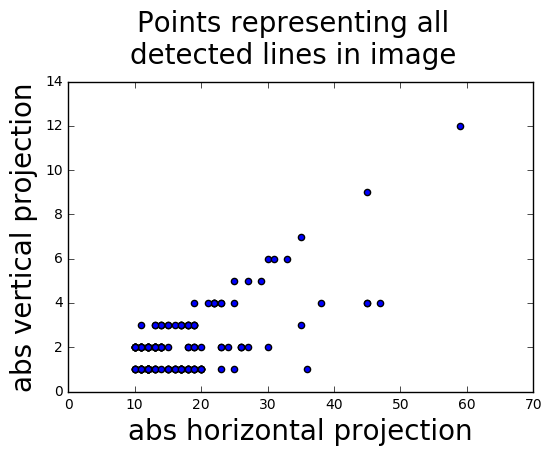

In [4]:
import pylab
# slope displayed in 2D
m2d = np.absolute(np.column_stack((lines[:,2] - lines[:,0], lines[:,3] - lines[:,1])))
fig, ax = plt.subplots()
fig.suptitle('Points representing all\ndetected lines in image\n\n', fontsize=20, y = 1.08)
ax.scatter(m2d[:,0],m2d[:,1])
ax.set_xlabel('abs horizontal projection', fontsize=20)
ax.set_ylabel('abs vertical projection', fontsize=20)


/home/pboord/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


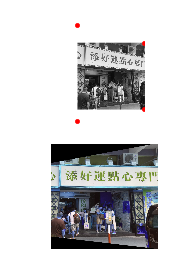

In [5]:
import math
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage import transform as tf

src = np.array([[0, 0], [0, H], [W, H], [W, 0]])
dst = np.array([[0, a], [0, b], [W, H], [W, 0]])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(img, tform3, output_shape=img.shape)
#warped = tf.warp(img, tform3, output_shape=img.shape)
imsave(pathname+'/warped.jpg',warped)
cv2.imshow('warped',warped)

fig, figAx = plt.subplots(nrows=2, figsize=(8, 3))

figAx[0].imshow(gray, cmap=plt.cm.gray)
figAx[0].plot(dst[:, 0], dst[:, 1], '.r')
#figAx[1].imshow(warped, cmap=plt.cm.gray)
figAx[1].imshow(warped)

for ax in figAx:
    ax.axis('off')
    
cv2.waitKey(0) 
cv2.destroyAllWindows()

In [ ]:
# attempt using Sobel derivates did not work...
# ksize = 3
# # dx = cv2.Sobel(gray, cv2.CV_16S, 1, 0, ksize)
# # dy = cv2.Sobel(gray, cv2.CV_16S, 0, 1, ksize)
# dx = cv2.Scharr(gray, cv2.CV_16S, 1, 0)
# dy = cv2.Scharr(gray, cv2.CV_16S, 0, 1)
# with np.errstate(divide='ignore', invalid='ignore'):
#     m = np.true_divide(dy,dx)
# m[ dx == 0 ] = 0
# # # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
# # k = 0.04
# # eig = cv2.cornerEigenValsAndVecs(gray, 5, 3)
# # eigVal0 = eig[:,:,0]
# # eigVal1 = eig[:,:,1]
# # R = np.multiply(eigVal0,eigVal1) - k*(eigVal0 + eigVal1)**2
# # isEdge = R < 0

# # # discard non-edges
# # m[np.logical_not(isEdge)] = 0
# # cv2.imshow('posSlope', np.multiply(m, m > 0))
# # cv2.imshow('negSlope', -1*np.multiply(m, m < 0))
# # cv2.waitKey(0) 
# # cv2.destroyAllWindows()

# hwIdx = np.unravel_index(range(0,H*W),(H, W))
# hIdx = hwIdx[0]
# wIdx = hwIdx[1]
# m = np.reshape(m,[-1,])


# #isEdge = np.reshape(isEdge,[-1,])


# # # bl2tr = -
# # # limit slope values
# # m_thresh = 0.5*h/w
# # selectEdge = np.logical_and(isEdge, np.absolute(m) < m_thresh)
# # # only consider selected edges
# # hIdx = hIdx[selectEdge]
# # wIdx = wIdx[selectEdge]
# # m = m[selectEdge]
# # a = np.column_stack( ( np.ones((m.shape[0],)), m ) )
# # b = hIdx - m*wIdx
# # x = np.linalg.lstsq(a,b)
# # x

# # bl2tr = +
# # limit slope values
# m_thresh = 0.8*H/W
# #cannyEdge =np.reshape(cannyEdge,[-1,])
# #selectEdge = np.logical_and(np.logical_and(isEdge, np.absolute(m) < m_thresh), cannyEdge > 0)

# selectEdge = m != 0
# #selectEdge = isEdge

# # only consider selected edges
# hIdx = hIdx[selectEdge]
# wIdx = wIdx[selectEdge]
# m = m[selectEdge]
# # Solve Ax = B
# A = np.column_stack( ( np.ones((m.shape[0],)), -m ) )
# B = hIdx + m*wIdx
# x = np.linalg.lstsq(A, B)
# g = x[0][0]
# # Why x[0][1] is negative?!?
# # And why is Sobel output negated?? ... related?
# d = x[0][1]
# a = g - d*g/(d + W)
# b = d*(H - g)/(d + W) + g
# a,b,g,d

In [ ]:
# unused stuff
#
# k = 0.04
# eig = cv2.cornerEigenValsAndVecs(gray, 5, 3)
# eigVal0 = eig[:,:,0]
# eigVal1 = eig[:,:,1]
# x0 = eig[:,:,2]
# y0 = eig[:,:,3]
# x1 = eig[:,:,4]
# y1 = eig[:,:,5]
# # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
# R = np.multiply(eigVal0,eigVal1) - k*(eigVal0 + eigVal1)**2
# isEdge = R < 0
# with np.errstate(divide='ignore', invalid='ignore'):
#     m0 = np.true_divide(y0,x0)
# m0[ x0 == 0 ] = 0
# with np.errstate(divide='ignore', invalid='ignore'):
#     m1 = np.true_divide(y1,x1)
# m1[ x1 == 0 ] = 0
# m = np.multiply(eigVal0 > eigVal1, m0) + np.multiply(eigVal1 > eigVal0, m1)
# hwIdx = np.unravel_index(range(0,h*w),(h,w))
# hIdx = hwIdx[0]
# wIdx = hwIdx[1]
# m = np.reshape(m,[-1,])
# isEdge = np.reshape(isEdge,[-1,])
# # only consider edges
# hIdx = hIdx[isEdge]
# wIdx = wIdx[isEdge]
# m = m[isEdge]


# # edgeSlopes = np.multiply(isEdge,m)
# # posSlopeEdge = np.multiply(edgeSlopes, edgeSlopes > 0)
# # negSlopeEdge = np.multiply(edgeSlopes, edgeSlopes < 0)
# # cv2.imshow('posSlope', posSlopeEdge)
# # cv2.imshow('negSlope', -1*negSlopeEdge)
# # cv2.waitKey(0) 
# # cv2.destroyAllWindows()


In [ ]:
m1d = np.absolute(np.true_divide(lines[:,3] - lines[:,1], lines[:,2] - lines[:,0])).T
plt.hist(m1d, bins=np.linspace(0,2,10))
plt.show()

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))